***Compare GA, SFS, PCA, Shapley, Feature Importance using RidgeCV, XGB, and neural net for Nitrogen, Carbon, Cellulose, Lignin, Water***
- 5-fold cross validation to estimate the error
- do the same for feature importance runs -- each time I do a cross val run, save the feature importance and take the average over all to get the top features

What if we get feature importance first and then run lazyregressor?

Pick 1 prediction method (like XGB), do a for loop through different numbers of Shap values, put the results into a df, and plot the results


***This is SUPER interesting -- the top features are the same for Shap and perm importance using XGB with 5-fold cv!!!***
- Run prediction models using only the top 100 features from each (remove duplicate bands).

In [1]:
#import spcdal
import os
import spectral
from spectral import envi
from spectral import resampling
import numpy as np
import matplotlib.pyplot as plt
import lazypredict
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import itertools

# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,7)})

In [2]:
def read_txt_2_list(fname):
    my_file = open(fname, "r") 
    data_list = my_file.read().split('\n')
    my_file.close() 
    return data_list


In [3]:
metadata_keys = [
    'Full Name',
    'Sensor',
    'Name',
    'Type',
    'Class',
    'Subclass',
    'Particle Size',
    'Sample No.',
    'Owner',
    'Wavelength Range:',
    'Origin',
    'Collection Date',
    'Description',
    'Measurement',
    'First Column',
    'Second Column',
    'X Units',
    'Y Units',
    'First X Value',
    'Last X Value',
    'Number of X Values',
    'Additional Information',
    'Class Metadata'
    'Name',
    'Type',
    'Class',
    'Genus',
    'Species',
    'Sample No.',
    'Owner',
    'Chemistry',
    'Biophysical Properties',
    'Sampling Notes',
    'Citation',
    'Particle Size',
    'Sample No.',
    'Owner',
    'Wavelength Range',
    'Origin',
    'Collection Date',
    'Description',
    'Mineral',
    'File Name',
    'XRD Analysis',
    'Spectrum',
    'Wl'
]

In [4]:
def read_data(fname, data):
    my_file = open(fname, "r", errors="ignore") 
    data_list = my_file.read().split('\n')
    my_file.close() 
    
    reading_header = True
    #wl = []
    #spec = []
    for row in data_list:
        row = row.strip()
        if len(row)>0:
            
            if reading_header:
                #print('reading header')
                # If reading the header portion of the file
                idx = row.find(':')
                data[row[:idx]] = row[(idx+1):].strip()
                if row[:idx]=='Additional Information':
                    reading_header = False
                    wl = []
                    spec = []
                
            else:
                #print('reading data')
                #print(row)
                # If reading the spectrum and wavelength portion of the file
                try:
                    wl.append(float(row[:row.find('.')+5]))  
                    spec.append(float(row[(row.rfind('.')-2):]))
                except:
                    wl.append(float(row[(row.find('\t')+2):]))                     
                    spec.append(float(row[row.find('\t'):])) 

    if reading_header == False:
        data['Spectrum'] = np.asarray(spec).flatten()
        data['Wl'] = np.asarray(wl).flatten()
        
    return data

In [6]:
# Single File Reading Example
dir = 'ECOSTRESS_ecospeclib_1687305441890\ecospeclib-veg'
fname = 'vegetation.grass.avena.fatua.tir.vh352.ucsb.nicolet.spectrum.txt'
data = dict.fromkeys(metadata_keys, None)  
data = read_data(os.path.join(dir,fname), data)
# Prints the nicely formatted dictionary
import pprint
pprint.pprint(data)

In [7]:
import pprint
pprint.pprint(data)

{'Additional Information': None,
 'Biophysical Properties': None,
 'Chemistry': None,
 'Citation': None,
 'Class': None,
 'Class MetadataName': None,
 'Collection Date': None,
 'Description': None,
 'File Name': None,
 'First Column': None,
 'First X Value': None,
 'Full Name': None,
 'Genus': None,
 'Last X Value': None,
 'Measurement': None,
 'Mineral': None,
 'Name': None,
 'Number of X Values': None,
 'Origin': None,
 'Owner': None,
 'Particle Size': None,
 'Sample No.': None,
 'Sampling Notes': None,
 'Second Column': None,
 'Sensor': None,
 'Species': None,
 'Spectrum': None,
 'Subclass': None,
 'Type': None,
 'Wavelength Range': None,
 'Wavelength Range:': None,
 'Wl': None,
 'X Units': None,
 'XRD Analysis': None,
 'Y Units': None}


In [ ]:
dir = 'Ecostress_Veg_Data/eco_veg/'
dir_list = os.listdir(dir)
sensors = []
data = {}
for fname in dir_list:
    data_keys = list(data.keys())
    
    if 'spectrum' in fname:
        fullname_sensor = fname[:(fname.find('spectrum')-1)]
        full_name = fullname_sensor[:(fullname_sensor.rfind('.'))]
        if fullname_sensor not in data_keys:
            data[fullname_sensor] = dict.fromkeys(metadata_keys, None)  
        data[fullname_sensor]['Full Name'] = full_name
        data[fullname_sensor] = read_data(os.path.join(dir,fname), data[fullname_sensor])
        wl_start = np.min([float(data[fullname_sensor]['First X Value']),float(data[fullname_sensor]['Last X Value'])])
        wl_end = np.max([float(data[fullname_sensor]['First X Value']),float(data[fullname_sensor]['Last X Value'])])
        sensor = (fullname_sensor[(fullname_sensor.rfind('.')+1):]+
                '_'+str(data[fullname_sensor]['Number of X Values'])+
                '_'+str(wl_start)[:4]+
                '_'+str(wl_end)[:4])
        data[fullname_sensor]['Sensor'] = sensor
        sensors.append(sensor)
        
    if 'ancillary' in fname:
        fullname_sensor = fname[:(fname.find('ancillary')-1)]
        full_name = fullname_sensor[:(fullname_sensor.rfind('.'))]
        sensors.append(sensor)
        if fullname_sensor not in data_keys:
            data[fullname_sensor] = dict.fromkeys(metadata_keys, None)  
        data[fullname_sensor]['Full Name'] = full_name
        data[fullname_sensor] = read_data(os.path.join(dir,fname), data[fullname_sensor])

sensors = np.unique(sensors)
sensors

array(['asd_2151_0.35_2.5', 'becknic_550_0.30_14.0',
       'nicolet_1736_2.50_15.3', 'nicolet_1737_2.50_15.3'], dtype='<U22')

In [ ]:
# convert to spectral libraries and save files
data_keys = list(data.keys())

#Iterate through the sensors
count = 0
for sensor in sensors:
    #print('sensor' + sensor)
    fname_lib = 'ecostrs_'+sensor
    read_wl = True
    # build the header
    header = {}
    header['spectra names'] = []
    header['chemistry_water'] = []
    header['chemistry_nitrogen'] = []
    header['chemistry_carbon'] = []
    #print('header: ', header)
    
    # Iterate through the spectra
    for k in data_keys:
        #print(k)
        d = data[k]
        # Check if this spectra was collected using current sensor
        if d['Sensor']==sensor:               
            # get the sensor info (wavelengths and possibly fwhm)
            if read_wl:
                header['wavelength'] = list(d['Wl'])
                read_wl = False

            water, nitrogen, carbon = '-1', '-1', '-1'
            
            if d['Chemistry'] is not None:
                original_array = d['Chemistry']
                #print('original_array: ',original_array)
                #water_content_list = []

                #for index, o_item in enumerate(original_array):
                    #print('o_items: ', o_item)
                if 'Water Content' in original_array:
                    # find water content
                    start_idx = original_array.find('Water Content') + 14
                    end_idx = original_array[start_idx:].find('%')
                    #print('start_end_index:',original_array[start_idx:(end_idx + start_idx)])
                    water = original_array[start_idx:(end_idx + start_idx)]

                #if 'Water Content' not in original_array:
                    #header['chemistry_water'].append('-1')
                    
                if 'Nitrogen' in original_array:
                    # find water content
                    start_idx = original_array.find('Nitrogen') + 9
                    end_idx = original_array[start_idx:].find('%')
                    #print('start_end_index:',original_array[start_idx:(end_idx + start_idx)])
                    nitrogen = original_array[start_idx:(end_idx + start_idx)]
                    
                if 'Carbon' in original_array:
                    # find water content
                    start_idx = original_array.find('Carbon') + 7
                    end_idx = original_array[start_idx:].find('%')
                    #print('start_end_index:',original_array[start_idx:(end_idx + start_idx)])
                    carbon = original_array[start_idx:(end_idx + start_idx)]

            header['chemistry_water'].append(water)
            header['chemistry_nitrogen'].append(nitrogen)
            header['chemistry_carbon'].append(carbon)
            #print('Header_Chemistry: ',header['chemistry_water'])  
            
            # add the spectra name and values  
            header['spectra names'].append(d['Full Name'])
            # add the data for the spectrum
            if len(header['spectra names'])==1:
                spectra_arr = d['Spectrum']
                #spectra_arr = (d['Spectrum'], d['Wl'])
                #print('spectra_arr shape: ', spectra_arr.shape)
                #print('d_spec shape: ', d['Spectrum'].shape)
            else:
                #print('else line 1: ', spectra_arr.shape)
                spectra_arr = np.vstack((spectra_arr,d['Spectrum']))  
                #print('else line 3: ', spectra_arr.shape)
            #print('header with spectra names', header)
            
    # save the collection as an ENVI spectral library
    #if len(header['spectra names'])>1:
    lib = envi.SpectralLibrary(spectra_arr, header, [])
    lib.save(fname_lib)

    print(fname_lib+'   Number of Spectra: '+str(len(header['spectra names'])))
    count = count + len(header['spectra names'])
    #else:   
        #pass
        # Not saving a library with only 1 spectrum     
        #print('Rejecting '+header['spectra names'][0])
        #print('  Because only one spectrum is present')
        
print('Total Number of Spectra in All Libraries: '+str(count))

ecostrs_asd_2151_0.35_2.5   Number of Spectra: 553
ecostrs_becknic_550_0.30_14.0   Number of Spectra: 3
ecostrs_nicolet_1736_2.50_15.3   Number of Spectra: 4
ecostrs_nicolet_1737_2.50_15.3   Number of Spectra: 480
Total Number of Spectra in All Libraries: 1040


In [ ]:
lib = envi.open('ecostrs_asd_2151_0.35_2.5.hdr')
print(lib.names[55],',',lib.metadata['chemistry_water'][55],',',lib.metadata['chemistry_nitrogen'][55])

vegetation.tree.quercus.rubra.vswir.jpl189.jpl , 53.53 , -1


In [ ]:
### TESTING ###

# convert to spectral libraries and save files
#data_keys = list(data.keys())
data_keys = ['vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd']

#Iterate through the sensors
count = 0
for sensor in sensors:
    print('sensor' + sensor)
    fname_lib = 'ecostrs_'+sensor
    read_wl = True
    # build the header
    header = {}
    header['spectra names'] = []
    header['chemistry_water'] = []
    print('header: ', header)
    
    # Iterate through the spectra
    for k in data_keys:
        print(k)
        d = data[k]
        # Check if this spectra was collected using current sensor
        if d['Sensor']==sensor:               
            # get the sensor info (wavelengths and possibly fwhm)
            if read_wl:
                header['wavelength'] = list(d['Wl'])
                read_wl = False
        
            if d['Chemistry'] is not None:
                original_array = d['Chemistry']
                print('original_array: ',original_array)
                water_content_list = []

                #for index, o_item in enumerate(original_array):
                    #print('o_items: ', o_item)
                if 'Water Content' in original_array:
                    # find water content
                    start_idx = original_array.find('Water Content') + 14
                    end_idx = original_array[start_idx:].find('%')
                    print('start_end_index:',original_array[start_idx:(end_idx + start_idx)])
                    water = original_array[start_idx:(end_idx + start_idx)]
                    #print('start_idx:', start_idx)
                    #array_string = original_array[index]
                    #split_array = array_string.split(';')
                    #for item in split_array:
                     #   if 'Water Content' in item:
                      #      water_content_value = item.split(':')[1].strip('%')
                    water_content_list.append(water)

                       # water_content_value = None

                print('water_content_list:', water_content_list)
            
                header['chemistry_water'].append(water_content_list)
                print('header_chem: ',header['chemistry_water'])

sensorasd_2151_0.35_2.5
header:  {'spectra names': [], 'chemistry_water': []}
vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd
original_array:  Water Content: 38.37%
start_end_index:  38.37
water_content_list: [' 38.37']
header_chem:  [[' 38.37']]
sensorbecknic_550_0.30_14.0
header:  {'spectra names': [], 'chemistry_water': []}
vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd
sensornicolet_1736_2.50_15.3
header:  {'spectra names': [], 'chemistry_water': []}
vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd
sensornicolet_1737_2.50_15.3
header:  {'spectra names': [], 'chemistry_water': []}
vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd


In [ ]:
data['vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd']['Chemistry']
data['vegetation.tree.magnolia.grandiflora.vswir.jpl116.jpl.asd']['Spectrum']

x = lib.spectra

In [ ]:
lib = envi.open('ecostrs_asd_2151_0.35_2.5.hdr')
print(lib.spectra)
print(lib.metadata['chemistry_water'])
print(lib.metadata['chemistry_nitrogen'])

[[ 6.289  5.923  5.708 ...  7.829  7.833  7.83 ]
 [ 4.474  4.301  4.329 ...  5.631  5.67   5.735]
 [ 6.408  6.233  6.217 ... 10.126 10.087 10.096]
 ...
 [ 2.657  2.493  2.346 ...  2.598  2.641  2.679]
 [ 2.217  2.298  2.204 ...  3.321  3.483  3.564]
 [ 2.708  2.689  2.537 ...  4.664  4.682  4.783]]
['-1', '-1', '-1', '-1', '54.89', '74.13', '51.61', '65.19', '52.38', '64.92', '45.41', '50.55', '45.36', '51.54', '45.62', '47.91', '42.14', '40.64', '41.3', '40.96', '39.03', '36.14', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '46.12', '46.22', '45.82', '48.61', '46.67', '44.34', '43.89', '61.65', '46.86', '61.58', '45.94', '58.33', '41.07', '42.98', '42.07', '43.57', '40.16', '40.32', '76.85', '72.92', '71.91', '71.72', '74.68', '75.35', '50.76', '69.18', '49.36', '61.49', '47.12', '50.94', '73.17', '69.08', '75', '66.67', '71.35', '68.82', '50.2', '50.56', '52.05', '55.31', '53.23', '56.87', '66.95', '64.24', '63.76', '61.47', '55', '56.67', '45.61', '47.77', '45.6

In [ ]:
### GET WATER FROM ASD ###

lib = envi.open('ecostrs_asd_2151_0.35_2.5.hdr')

X1=[]
y=[]
feature_names=np.asarray(lib.bands.centers)

for name,i in enumerate(lib.names):
    if lib.metadata['chemistry_water'][name] != '-1':
        X1.append(lib.spectra[name])
        y.append(float(lib.metadata['chemistry_water'][name]))

X1 = np.array(X1)
y = np.array(y)

X = np.zeros(X1.shape)
for i in range(X.shape[0]):
    X[i,:] = (X1[i,:] - np.min(X1[i,:]))/np.linalg.norm((X1[i,:] - np.min(X1[i,:])))

In [ ]:
### GET NITROGEN FROM ASD ###

lib = envi.open('ecostrs_asd_2151_0.35_2.5.hdr')

X1_asd_n=[]
y_asd_n=[]
feature_names=np.asarray(lib.bands.centers)

for name,i in enumerate(lib.names):
    if lib.metadata['chemistry_nitrogen'][name] != '-1':
        X1_asd_n.append(lib.spectra[name])
        y_asd_n.append(float(lib.metadata['chemistry_nitrogen'][name]))

X1_asd_n = np.array(X1_asd_n)
y_asd_n = np.array(y_asd_n)


X_asd_n = np.zeros(X1_asd_n.shape)

# min-max normalization
for i in range(X_asd_n.shape[0]):
    X_asd_n[i,:] = (X1_asd_n[i,:] - np.min(X1_asd_n[i,:]))/np.linalg.norm((X1_asd_n[i,:] - np.min(X1_asd_n[i,:])))

In [ ]:
### GET CARBON FROM ASD ###

lib = envi.open('ecostrs_asd_2151_0.35_2.5.hdr')

X1_asd_c=[]
y_asd_c=[]
feature_names=np.asarray(lib.bands.centers)

for name,i in enumerate(lib.names):
    if lib.metadata['chemistry_carbon'][name] != '-1':
        X1_asd_c.append(lib.spectra[name])
        y_asd_c.append(float(lib.metadata['chemistry_carbon'][name]))

X1_asd_c = np.array(X1_asd_c)
y_asd_c = np.array(y_asd_c)


X_asd_c = np.zeros(X1_asd_c.shape)

# min-max normalization
for i in range(X_asd_c.shape[0]):
    X_asd_c[i,:] = (X1_asd_c[i,:] - np.min(X1_asd_c[i,:]))/np.linalg.norm((X1_asd_c[i,:] - np.min(X1_asd_c[i,:])))

In [ ]:
### GET WATER FROM NICOLET ###

lib_nic = envi.open('ecostrs_nicolet_1737_2.50_15.3.hdr')

X1_nic_w=[]
y_nic_w=[]
feature_names_nic=np.asarray(lib_nic.bands.centers)

for name,i in enumerate(lib_nic.names):
    if lib_nic.metadata['chemistry_water'][name] != '-1':
        X1_nic_w.append(lib_nic.spectra[name])
        y_nic_w.append(float(lib_nic.metadata['chemistry_water'][name]))

X1_nic_w = np.array(X1_nic_w)
y_nic_w = np.array(y_nic_w)


X_nic_w = np.zeros(X1_nic_w.shape)

# min-max normalization
for i in range(X_nic_w.shape[0]):
    X_nic_w[i,:] = (X1_nic_w[i,:] - np.min(X1_nic_w[i,:]))/np.linalg.norm((X1_nic_w[i,:] - np.min(X1_nic_w[i,:])))

In [ ]:
### GET NITROGEN FROM NICOLET ###

lib_nic = envi.open('ecostrs_nicolet_1737_2.50_15.3.hdr')

X1_nic_n=[]
y_nic_n=[]
feature_names_nic=np.asarray(lib_nic.bands.centers)

for name,i in enumerate(lib_nic.names):
    if lib_nic.metadata['chemistry_nitrogen'][name] != '-1':
        X1_nic_n.append(lib_nic.spectra[name])
        y_nic_n.append(float(lib_nic.metadata['chemistry_nitrogen'][name]))

X1_nic_n = np.array(X1_nic_n)
y_nic_n = np.array(y_nic_n)


X_nic_n = np.zeros(X1_nic_n.shape)

# min-max normalization
for i in range(X_nic_n.shape[0]):
    X_nic_n[i,:] = (X1_nic_n[i,:] - np.min(X1_nic_n[i,:]))/np.linalg.norm((X1_nic_n[i,:] - np.min(X1_nic_n[i,:])))

In [ ]:
### GET CARBON FROM NICOLET ###

lib_nic = envi.open('ecostrs_nicolet_1737_2.50_15.3.hdr')

X1_nic_c=[]
y_nic_c=[]
feature_names_nic=np.asarray(lib_nic.bands.centers)

for name,i in enumerate(lib_nic.names):
    if lib_nic.metadata['chemistry_carbon'][name] != '-1':
        X1_nic_c.append(lib_nic.spectra[name])
        y_nic_c.append(float(lib_nic.metadata['chemistry_carbon'][name]))

X1_nic_c = np.array(X1_nic_c)
y_nic_c = np.array(y_nic_c)


X_nic_c = np.zeros(X1_nic_c.shape)

# min-max normalization
for i in range(X_nic_c.shape[0]):
    X_nic_c[i,:] = (X1_nic_c[i,:] - np.min(X1_nic_c[i,:]))/np.linalg.norm((X1_nic_c[i,:] - np.min(X1_nic_c[i,:])))

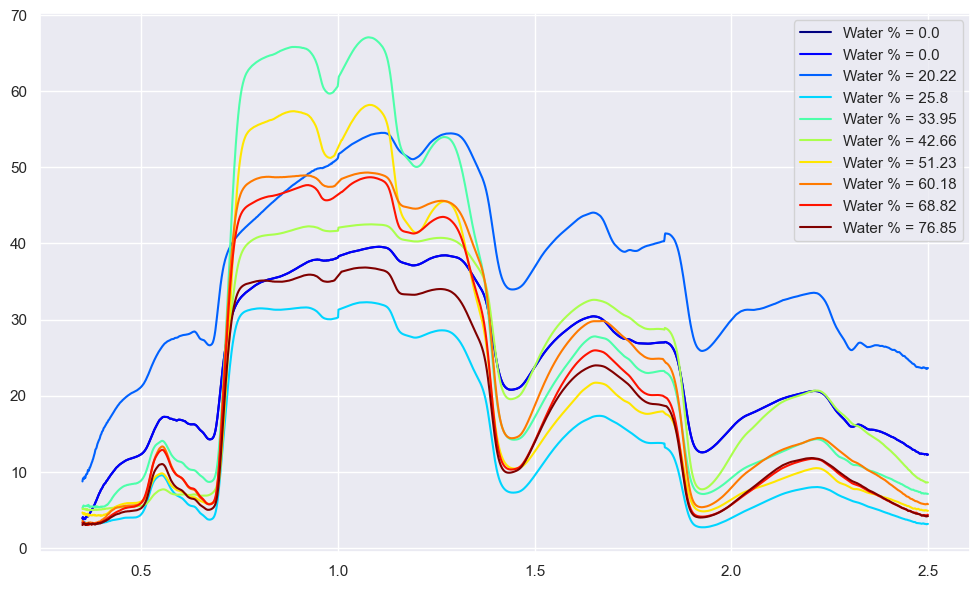

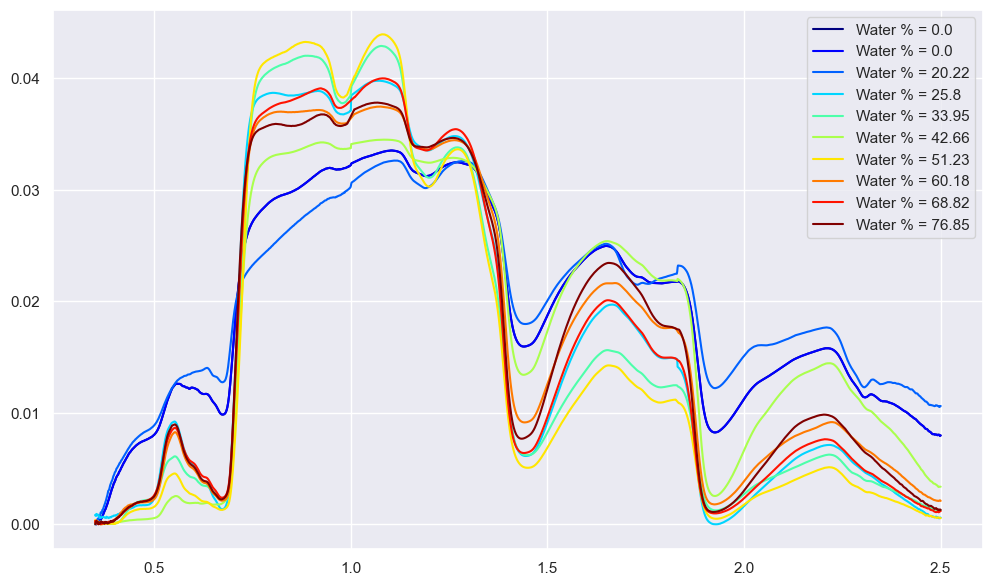

In [ ]:
# plot n spectra with a variation in water content
n = 10
min_water = np.min(y)
max_water = np.max(y)
selected_water = np.linspace(min_water, max_water, num=n)
idx = []
for water in selected_water:
    idx.append(np.argmin(np.abs(y-water)))


colors = plt.cm.jet(np.linspace(0,1,n))

plt.figure()
for i,c in zip(idx,colors):
    plt.plot(feature_names,X1[i,:], label=f'Water % = {y[i]}', c=c)
plt.legend();

plt.figure()
for i,c in zip(idx,colors):
    plt.plot(feature_names,X[i,:], label=f'Water % = {y[i]}', c=c)
plt.legend();

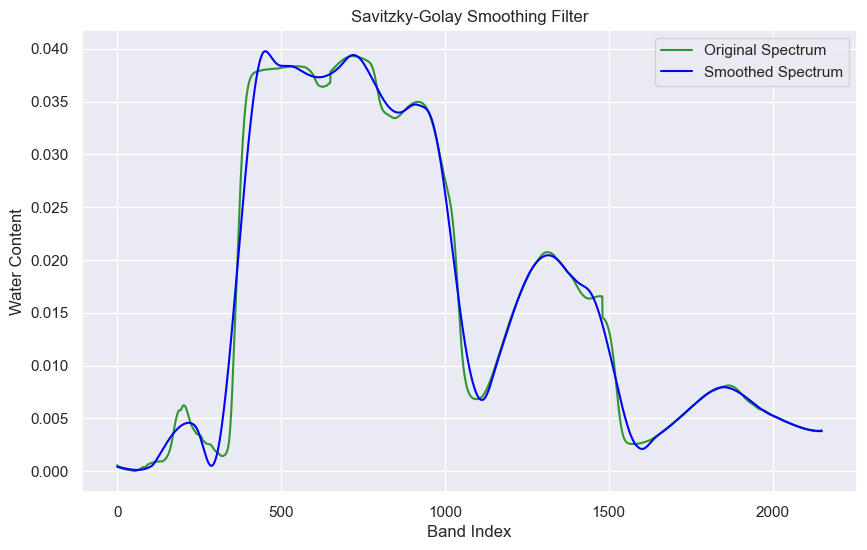

In [ ]:
### Savitzky-Golay smoothing filter ###

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

num_samples = len(X)
num_bands = len(X[0])

# Apply Savitzky-Golay smoothing filter to each spectrum
smoothed_X = np.zeros_like(X)
window_length = 215  # 2151 bands divided by 10
polyorder = 3      # Adjust as needed
for i in range(num_samples):
    smoothed_X[i] = savgol_filter(X[i], window_length=window_length, polyorder=polyorder)

# Plot original and smoothed spectra
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_bands), X[0], label='Original Spectrum', color='green', alpha=0.8)
plt.plot(np.arange(num_bands), smoothed_X[0], label='Smoothed Spectrum', color='blue')
plt.xlabel('Band Index')
plt.ylabel('Water Content')
plt.title('Savitzky-Golay Smoothing Filter')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Run lazypredict for water content using all 2151 ASD features

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state = 42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 26%|██▌       | 11/42 [02:22<05:51, 11.35s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 55%|█████▍    | 23/42 [05:02<04:49, 15.24s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 79%|███████▊  | 33/42 [05:06<00:08,  1.05it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 368.


 98%|█████████▊| 41/42 [06:02<00:04,  4.75s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264542
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 2151
[LightGBM] [Info] Start training from score 46.690815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 42/42 [06:03<00:00,  8.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                                    Adjusted R-Squared  \
Model                                                    
SGDRegressor                  484649826242990440448.00   
LarsCV                              689060782467339.00   
Lars                                689060782467339.00   
GaussianProcessRegressor                          1.74   
KernelRidge                                       1.69   
ExtraTreeRegressor                                1.05   
DummyRegressor                                    1.04   
Lasso                                             1.04   
LassoLars                                         1.04   
NuSVR                                             1.04   
SVR                                               1.04   
OrthogonalMatchingPur

In [ ]:
# Run lazypredict for nitrogen content using all 2151 ASD features

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_asd_n, y_asd_n,test_size=0.2,random_state = 42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 55%|█████▍    | 23/42 [02:02<01:48,  5.72s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 74%|███████▍  | 31/42 [02:05<00:11,  1.03s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 241.


 98%|█████████▊| 41/42 [02:37<00:02,  2.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173806
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 2151
[LightGBM] [Info] Start training from score 1.420249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

100%|██████████| 42/42 [02:37<00:00,  3.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                                         Adjusted R-Squared  \
Model                                                         
Lars                          46319835737865544592785408.00   
SGDRegressor                     71248883778067032440832.00   
GaussianProcessRegressor                               1.14   
KernelRidge                                            1.13   
OrthogonalMatchingPurs

In [ ]:
# Run lazypredict for carbon content using all 2151 ASD features

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_asd_c, y_asd_c,test_size=0.2,random_state = 42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 57%|█████▋    | 24/42 [02:22<01:23,  4.62s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [02:26<00:07,  1.39it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 241.


 98%|█████████▊| 41/42 [02:59<00:02,  2.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 173806
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 2151
[LightGBM] [Info] Start training from score 48.436432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 42/42 [02:59<00:00,  4.28s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Run lazypredict for water content using all 1737 nicolet features

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_nic_w, y_nic_w,test_size=0.2,random_state = 42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 26%|██▌       | 11/42 [01:11<02:46,  5.37s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 55%|█████▍    | 23/42 [02:19<01:45,  5.58s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 74%|███████▍  | 31/42 [02:23<00:11,  1.05s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 313.


 98%|█████████▊| 41/42 [03:06<00:03,  3.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182148
[LightGBM] [Info] Number of data points in the train set: 313, number of used features: 1737
[LightGBM] [Info] Start training from score 48.234153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 42/42 [03:07<00:00,  4.46s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                                          Adjusted R-Squared  \
Model                                                          
Lars                          625610903517793878519316480.00   
SGDRegressor                        114160868630323118080.00   
KernelRidge                                             2.18   
GaussianProcessRegressor                                1.96   
OrthogonalMatchingPursuit                               1.27   
DecisionTreeRegressor                                   1.08   
ExtraTreeRegressor                                      1.07   
LinearRegression                                        1.07   
TransformedTargetRegressor                              1.07

In [ ]:
# Run lazypredict for nitrogen content using all 1737 nicolet features

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_nic_n, y_nic_n,test_size=0.2,random_state = 42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 55%|█████▍    | 23/42 [01:30<01:16,  4.03s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 74%|███████▍  | 31/42 [01:32<00:08,  1.33it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 241.


 95%|█████████▌| 40/42 [01:52<00:02,  1.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140690
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 1737
[LightGBM] [Info] Start training from score 1.434647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

100%|██████████| 42/42 [02:03<00:00,  2.94s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Run lazypredict for carbon content using all 1737 nicolet features

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_nic_c, y_nic_c,test_size=0.2,random_state = 42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 55%|█████▍    | 23/42 [01:44<01:20,  4.26s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 74%|███████▍  | 31/42 [01:47<00:10,  1.02it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 241.


 98%|█████████▊| 41/42 [02:12<00:01,  1.65s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140690
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 1737
[LightGBM] [Info] Start training from score 48.319212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 42/42 [02:12<00:00,  3.17s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Run lazypredict for water content with 5-fold cross validation ???  NOT RUNNING

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LazyRegressor object with 5-fold cross-validation
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True)

# Fit LazyRegressor on the training data
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Fit LazyRegressor using cross-validation
cv_scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the summary of model performance
print(cv_scores)
print(models)

 26%|██▌       | 11/42 [01:43<04:19,  8.37s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 55%|█████▍    | 23/42 [03:32<02:59,  9.46s/it]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.


 76%|███████▌  | 32/42 [03:36<00:11,  1.16s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 368.


 95%|█████████▌| 40/42 [04:24<00:05,  2.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264542
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 2151
[LightGBM] [Info] Start training from score 46.690815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

100%|██████████| 42/42 [04:39<00:00,  6.65s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


TypeError: Cannot clone object '<lazypredict.Supervised.LazyRegressor object at 0x7fcd88b237d0>' (type <class 'lazypredict.Supervised.LazyRegressor'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Root Mean Squared Error: 7.910178368467881


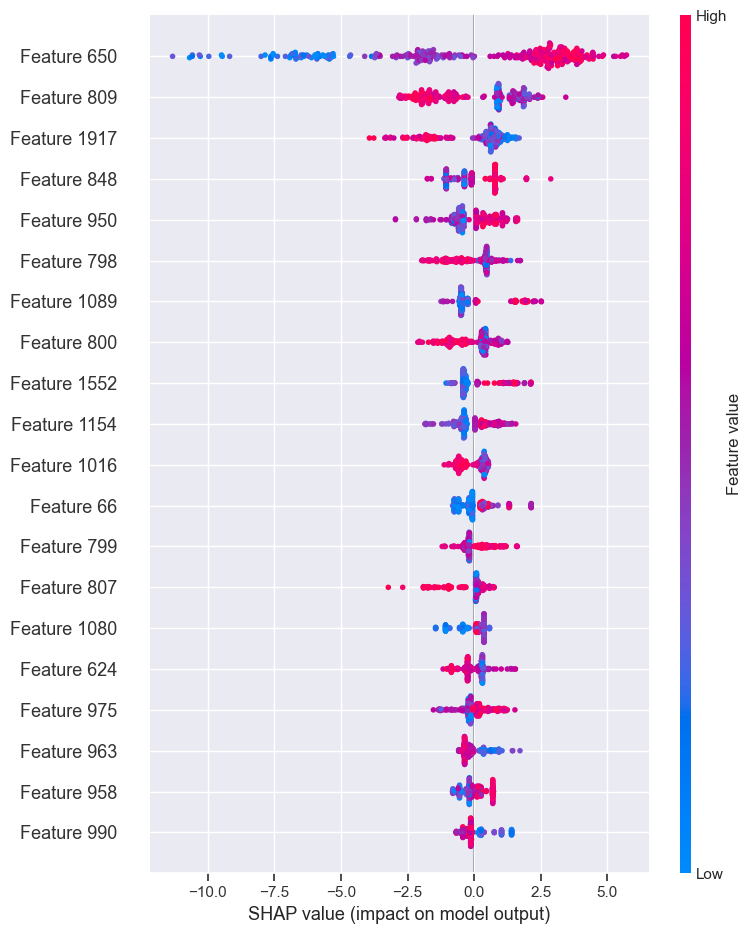

In [ ]:
### XGB USING TEST-TRAIN SPLIT ###

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model to training data
xgb_reg.fit(X_train, y_train)

# Predict on the testing data
y_pred = xgb_reg.predict(X_test)

# Create explainer object
explainer = shap.Explainer(xgb_reg, X_train)

# Compute Shapley values
shap_values = explainer.shap_values(X_train)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(mse)
print("Root Mean Squared Error:", xgb_rmse)

# Shapley summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
### GET PERMUTATION IMPORTANCE for XGB WITH TEST-TRAIN SPLIT ###

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model to training data
xgb_reg.fit(X_train, y_train)

# Calculate permutation importance
perm_impt = permutation_importance(xgb_reg, X_test, y_test, random_state=42, n_repeats=10, n_jobs=-1)

# Get feature importances
perm_importances = perm_impt.importances_mean

# Get indices of features sorted by importance
sorted_indices_perm_impt = perm_importances.argsort()[::-1]

# Print feature importances
for idx in sorted_indices_perm_impt:
    print(f"Feature {idx}: {perm_importances[idx]}")

Feature 650: 0.19083636126769604
Feature 809: 0.11704298393993469
Feature 848: 0.05268303054933998
Feature 66: 0.04904689255632292
Feature 807: 0.04178549657918311
Feature 950: 0.03296567689406259
Feature 1531: 0.02735779282837949
Feature 84: 0.025626826136582116
Feature 805: 0.022566984015072476
Feature 1023: 0.01974573444278078
Feature 1577: 0.017575065619269626
Feature 958: 0.01683056074048802
Feature 1024: 0.0154380701985263
Feature 798: 0.015206032569655071
Feature 1154: 0.014267168680176811
Feature 1537: 0.013305345776513022
Feature 804: 0.01267506404830493
Feature 41: 0.012647670676427835
Feature 1016: 0.01232934565716549
Feature 797: 0.011917771214296168
Feature 1057: 0.01158056627174714
Feature 455: 0.011225478486931274
Feature 800: 0.011087292934512072
Feature 201: 0.010705370673070081
Feature 963: 0.010544531280808456
Feature 3: 0.009973802847601443
Feature 794: 0.009486141692646898
Feature 1532: 0.0075720642023661576
Feature 56: 0.007551877198362755
Feature 2140: 0.00753853

Mean squared error for each fold: [85.26584972 62.10213605 49.21227898 76.04810612 76.60036277]
Average Mean squared error across all folds: 69.84574672830202
RMSE across all folds: 8.357376785110386


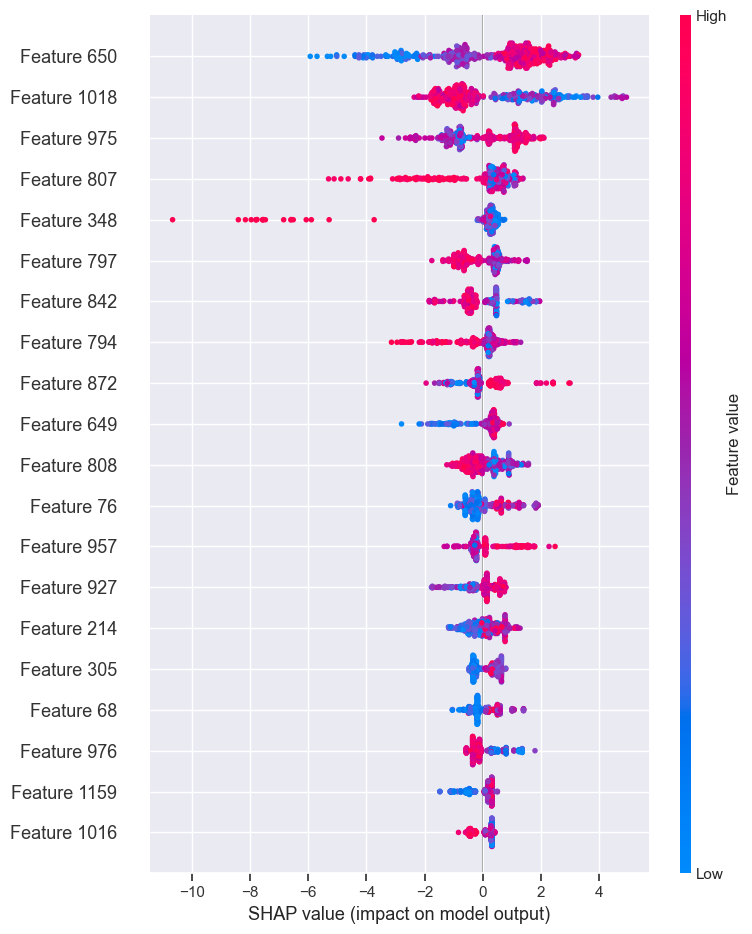

In [ ]:
### XGB WITH 5-FOLD CROSS VALIDATION AND SHAPLEY USING ALL DATA ###

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

reg_name= 'XGBoost with 5CV'

# Initialize XGBRegressor
xgb_reg_5cv = xgb.XGBRegressor(objective='reg:squarederror')

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Fit the model to all data
xgb_reg_5cv.fit(X,y)

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -xgb_cv_scores)
print("Average Mean squared error across all folds:", -np.mean(xgb_cv_scores))
print('RMSE across all folds:',np.sqrt(-np.mean(xgb_cv_scores)))

# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

In [ ]:
### GET PERMUTATION IMPORTANCE for XGB WITH 5-FOLD CROSS VALIDATION ###

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg, X, y, cv=kf, scoring='neg_mean_squared_error')

# Fit the model to all data
xgb_reg.fit(X,y)

# Calculate permutation importance
# perm_impt = permutation_importance(xgb_reg, X_test, y_test, random_state=42, n_repeats=10, n_jobs=-1)
perm_impt = permutation_importance(xgb_reg, X, y, n_repeats=10, n_jobs=-1)

# Get feature importances
perm_importances = perm_impt.importances_mean

# Get indices of features sorted by importance
sorted_indices_perm_impt = perm_importances.argsort()[::-1]

# Print feature importances
for idx in sorted_indices_perm_impt:
    print(f"Feature {idx}: {perm_importances[idx]}")

# Print mean cross-validation score
print("Mean CV Score:", np.mean(xgb_cv_scores))

Feature 650: 0.12195890226847958
Feature 1018: 0.08791686555888886
Feature 975: 0.061516056969084146
Feature 807: 0.061209374039328954
Feature 348: 0.05432381871101797
Feature 794: 0.03195611741381318
Feature 957: 0.020581865467813598
Feature 872: 0.020326784744561177
Feature 842: 0.019515580848107082
Feature 927: 0.017215671282573397
Feature 214: 0.01705188230364435
Feature 808: 0.01650384887938584
Feature 805: 0.016409677430842973
Feature 76: 0.01590756339158056
Feature 802: 0.012656735924136697
Feature 649: 0.011416282677956158
Feature 349: 0.010451979598000616
Feature 797: 0.01024956367589821
Feature 70: 0.009530609171056647
Feature 68: 0.008924138114198676
Feature 239: 0.008759647276776894
Feature 1359: 0.007982177252647249
Feature 339: 0.007613703040534658
Feature 180: 0.0074525080261559126
Feature 0: 0.007179599741685116
Feature 976: 0.007154317320361814
Feature 899: 0.0070692841879204885
Feature 868: 0.006393923918161815
Feature 966: 0.006387726175092345
Feature 863: 0.00618101

Mean squared error on test set: 4.95640247742602e-06
Root Mean Squared Error on Test Set: 0.0022262979309665676
R-squared on Test Set: 0.9999999564629569
          Regressor       MSE      RMSE  R-Squared
0  XGBoost with 5CV  0.000005  0.002226        1.0


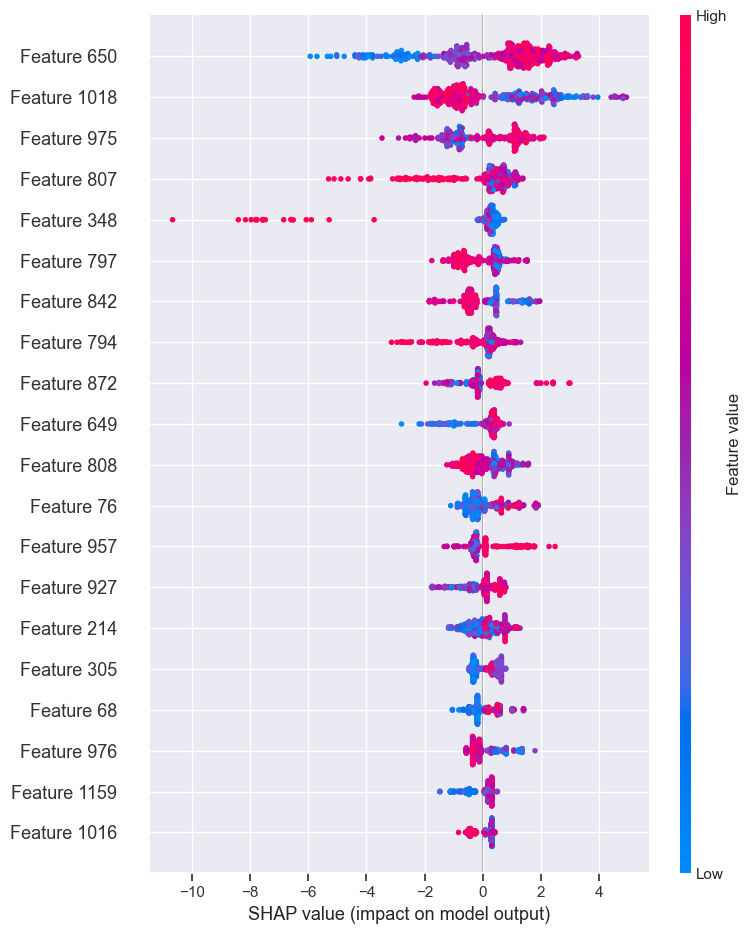

In [ ]:
### Don't worry about this for abstract ###

xgb_reg_5cv.fit(X,y)
    
# Predict on the testing data
y_pred_5cv = xgb_reg_5cv.predict(X)

# Calculate and print the mean squared error on the test set
xgb_mse_test_5cv = mean_squared_error(y, y_pred_5cv)
xgb_rmse_test_5cv = np.sqrt(xgb_mse_test_5cv)
print("Mean squared error on test set:", xgb_mse_test_5cv)
print("Root Mean Squared Error on Test Set:", xgb_rmse_test_5cv)
r_sq_test = r2_score(y, y_pred_5cv)
print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df_xgb = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [xgb_mse_test_5cv],
    'RMSE': [xgb_rmse_test_5cv],
    'R-Squared': [r_sq_test]})

print(results_df_xgb)

# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

Mean squared error for each fold: [56.4544046  62.7730666  34.82042143 99.08997582 63.18081774 33.51644136
 60.19315821 65.52821715 58.32112136 44.18169951]
Mean squared error across all folds: 57.80593237643798
Mean squared error on test set: 4.95640247742602e-06
Root Mean Squared Error on Test Set: 0.0022262979309665676


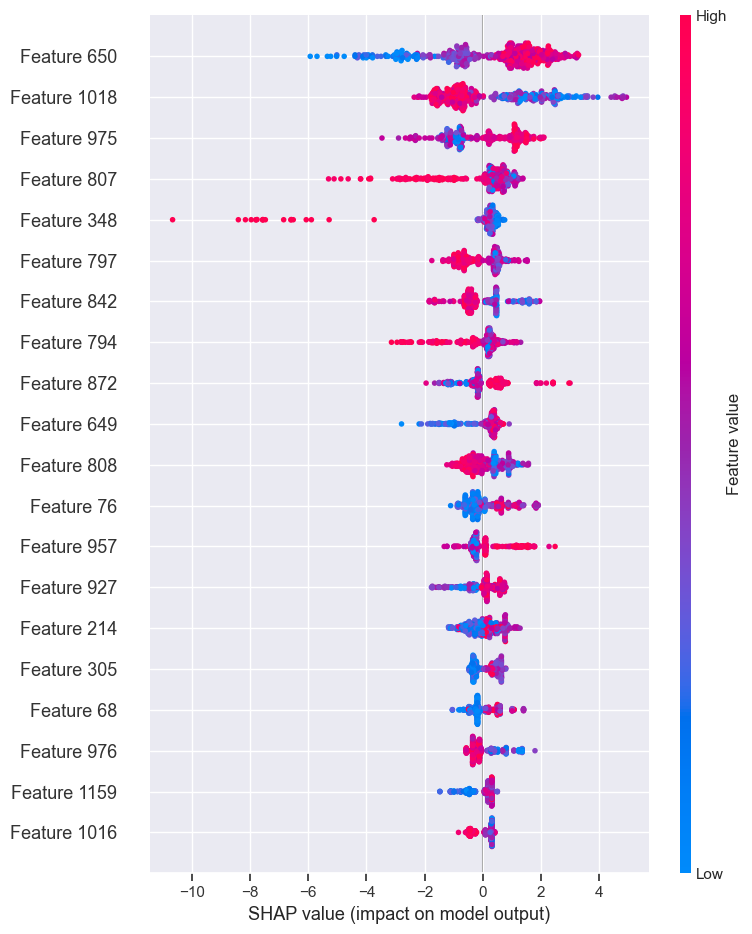

In [ ]:
### XGB WITH 10-FOLD CROSS VALIDATION AND SHAPLEY USING ALL DATA ###

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# Initialize XGBRegressor
xgb_reg_5cv = xgb.XGBRegressor(objective='reg:squarederror')

# Fit the model to all data
xgb_reg_5cv.fit(X,y)

# Define the KFold cross-validation object
kf = KFold(n_splits=10, shuffle=True)

# Perform 5-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -xgb_cv_scores)
print("Mean squared error across all folds:", -np.mean(xgb_cv_scores))


# Predict on the testing data
y_pred_5cv = xgb_reg_5cv.predict(X)

# Calculate and print the mean squared error on the test set
xgb_mse_test_5cv = mean_squared_error(y, y_pred_5cv)
xgb_rmse_test_5cv = np.sqrt(xgb_mse_test_5cv)
print("Mean squared error on test set:", xgb_mse_test_5cv)
print("Root Mean Squared Error on Test Set:", xgb_rmse_test_5cv)

# Create explainer object
explainer_5cv = shap.Explainer(xgb_reg_5cv, X)

# Compute Shapley values
shap_values_5cv = explainer_5cv.shap_values(X)

# Calculate mean squared error
#mse_5cv = mean_squared_error(y, y_pred_5cv)
#xgb_rmse_5cv = np.sqrt(mse_5cv)
#print("Root Mean Squared Error:", xgb_rmse_5cv)

# Shapley summary plot
shap.summary_plot(shap_values_5cv, X)

In [ ]:
### RIDGE WITH 5-FOLD CROSS VALIDATION ###

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the Ridge Regression model
ridge_model = Ridge()

# Fit the model on the whole training set
ridge_model.fit(X, y)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the test set
y_pred = ridge_model.predict(X)

# Calculate and print the mean squared error on the test set
mse_test = mean_squared_error(y, y_pred)
rmse_test = np.sqrt(mse_test)
print("Mean squared error on test set:", mse_test)
print("Root Mean Squared Error on Test Set:", rmse_test)


Mean squared error for each fold: [108.46071267  73.73729338 121.04276018  98.17491524 118.24149817]
Mean squared error across all folds: 103.93143592828501
Mean squared error on test set: 102.0062462190588
Root Mean Squared Error on Test Set: 10.099814167550747


In [ ]:
### RIDGE WITH 5-FOLD CROSS VALIDATION ON Savitzky-Golay smoothed X ###

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the Ridge Regression model
ridge_model = Ridge()

# Fit the model on the whole training set
ridge_model.fit(smoothed_X, y)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ridge_model, smoothed_X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the test set
y_pred = ridge_model.predict(smoothed_X)

# Calculate and print the mean squared error on the test set
mse_test = mean_squared_error(y, y_pred)
rmse_test = np.sqrt(mse_test)
print("Mean squared error on test set:", mse_test)
print("Root Mean Squared Error on Test Set:", rmse_test)


Mean squared error for each fold: [ 91.53538707 123.90019851 127.89733005  75.46382908 109.95023075]
Mean squared error across all folds: 105.74939509398277
Mean squared error on test set: 102.39607111018944
Root Mean Squared Error on Test Set: 10.119094381919236


In [ ]:
### RIDGE WITH 5-FOLD CROSS VALIDATION ON X_shap_top10 ###

from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the Ridge Regression model
ridge_model = Ridge()

# Fit the model on the whole training set
ridge_model.fit(X_shap_top10, y)

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(ridge_model, X_shap_top10, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the test set
y_pred = ridge_model.predict(X_shap_top10)

# Calculate and print the mean squared error on the test set
mse_test = mean_squared_error(y, y_pred)
rmse_test = np.sqrt(mse_test)
print("Mean squared error on test set:", mse_test)
print("Root Mean Squared Error on Test Set:", rmse_test)


Root Mean Squared Error: 7.10620636747413


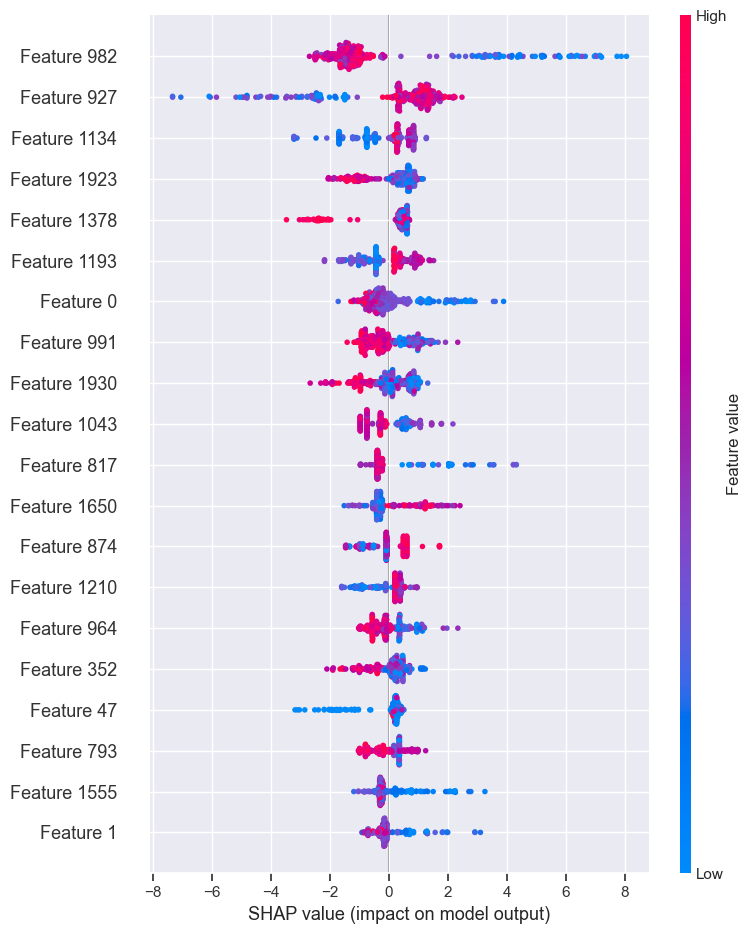

In [ ]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
smoothed_X_train, smoothed_X_test, smoothed_y_train, smoothed_y_test = train_test_split(smoothed_X, y, test_size=0.3, random_state=42)

# Initialize XGBRegressor
smoothed_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model to training data
smoothed_xgb_reg.fit(smoothed_X_train, smoothed_y_train)

# Predict on the testing data
smoothed_y_pred = smoothed_xgb_reg.predict(smoothed_X_test)

# Create explainer object
smoothed_explainer = shap.Explainer(smoothed_xgb_reg, smoothed_X_train)

# Compute Shapley values
smoothed_shap_values = smoothed_explainer.shap_values(smoothed_X_train)

# Calculate mean squared error
smoothed_mse = mean_squared_error(smoothed_y_test, smoothed_y_pred)
smoothed_xgb_rmse = np.sqrt(smoothed_mse)
print("Root Mean Squared Error:", smoothed_xgb_rmse)

# Shapley summary plot
shap.summary_plot(smoothed_shap_values, smoothed_X_train)

In [ ]:
### GET TOP SHAP VALUES IN A LIST ###

shap_top10_5cv = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values_5cv = np.mean(np.abs(shap_values_5cv), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices_5cv = np.argsort(mean_abs_shap_values_5cv)[::-1]  # Descending order

# Number of top features to select
num_top_features_5cv = 30

# Get the indices of the most important features
top_feature_indices_5cv = sorted_indices_5cv[:num_top_features_5cv]

for i in top_feature_indices_5cv:
    shap_top10_5cv.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 30 Shapley bands:", shap_top10_5cv)
print(top_feature_indices_5cv)
#print(top_feature_indices)


Top 30 Shapley bands: [1.0, 1.368, 1.325, 1.157, 0.698, 1.147, 1.192, 1.144, 1.222, 0.999, 1.158, 0.426, 1.307, 1.277, 0.564, 0.655, 0.418, 1.326, 1.509, 1.366, 1.155, 0.42, 0.53, 1.876, 1.213, 1.295, 0.693, 1.223, 0.362, 1.152]
[ 650 1018  975  807  348  797  842  794  872  649  808   76  957  927
  214  305   68  976 1159 1016  805   70  180 1526  863  945  343  873
   12  802]


In [ ]:
X_shap_top10 = []

for j,_ in enumerate(X):
    top10 = []
    for i in top_feature_indices_5cv:
        top10.append(X[j,i])
    X_shap_top10.append(top10)

X_shap_top10 = np.array(X_shap_top10)

print(len(X_shap_top10))

460


In [ ]:
X_shap_top10[0]

array([0.03678967, 0.02508251, 0.03133578, 0.03441711, 0.00571548,
       0.03562056, 0.03345625, 0.03612036, 0.034005  , 0.03677286,
       0.03434331, 0.00033904, 0.03343798, 0.03491764, 0.00560807,
       0.001807  , 0.00019217, 0.03119548, 0.01046207, 0.02545662,
       0.03458736, 0.00021117, 0.00502425, 0.00720464, 0.03370395,
       0.03432797, 0.00335169, 0.03403934, 0.0003427 , 0.03490814])

In [ ]:
### GET TOP 10 XGB FEATURE IMPORTANCE VALUES IN A LIST ###

xgb_top10_features_5cv = list(xgb_feature_importance_map_5cv.keys())  # These are the top 10 wavelengths.

X_xgb_top10_index = []

for i in xgb_top10_features_5cv:
    X_xgb_top10_index.append(lib.bands.centers.index(i))

X_xgb_top10_index

#xgb_feature_indices_5cv = list(xgb_feature_importance_map_5cv.keys())
#xgb_feature_indices_5cv.index(0.811)
#lib.bands.centers.index(0.811)

[975, 461, 218, 927, 794, 987, 807, 214, 872, 1018]

In [ ]:
# Combine the Shap and XGB indices

combined_top10_index = np.concatenate((top_feature_indices_5cv, X_xgb_top10_index))

print(len(combined_top10_index))
print(combined_top10_index)

20
[ 650 1018  975  807  348  797  842  794  872  649  975  461  218  927
  794  987  807  214  872 1018]


In [ ]:
X_xgb_top10 = []

for j,_ in enumerate(X):
    top10 = []
    for i in X_xgb_top10_index:
        top10.append(X[j,i])
    X_xgb_top10.append(top10)

X_xgb_top10 = np.array(X_xgb_top10)

print(X_xgb_top10[0])

[0.03133578 0.03805231 0.00516819 0.03491764 0.03612036 0.02954046
 0.03441711 0.00560807 0.034005   0.02508251]


In [ ]:
X_top_bands = []

for j,_ in enumerate(X):
    top = []
    for i in combined_top10_index:
        top.append(X[j,i])
    X_top_bands.append(top)

X_top_bands = np.array(X_top_bands)

print(len(X_top_bands))
print(X_top_bands[0])

460
[0.03678967 0.02508251 0.03133578 0.03441711 0.00571548 0.03562056
 0.03345625 0.03612036 0.034005   0.03677286 0.03133578 0.03805231
 0.00516819 0.03491764 0.03612036 0.02954046 0.03441711 0.00560807
 0.034005   0.02508251]


In [ ]:
for i in xgb_feature_indices_5cv:
    print(lib.bands.centers.index(i), ': ',i)

xgb_feature_indices_5cv = list(xgb_feature_importance_map_5cv.keys())
xgb_feature_indices_5cv.index(0.811)
lib.bands.centers.index(0.811)

In [ ]:
### Run lazypredict for water content using only top 10 Shap features ###

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_shap_top10, y,test_size=0.2)  #,random_state =23)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 79%|███████▊  | 33/42 [00:25<00:05,  1.80it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 95%|█████████▌| 40/42 [00:26<00:00,  2.63it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3686
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 30
[LightGBM] [Info] Start training from score 46.524293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

100%|██████████| 42/42 [00:28<00:00,  1.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
### Run lazypredict for water content using only top Shap + XGB features ###

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_top_bands, y,test_size=0.2)  #,random_state =23)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 21%|██▏       | 9/42 [00:00<00:02, 14.94it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|███████▊  | 33/42 [00:01<00:00, 23.77it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:02<00:00, 15.60it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2460
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 20
[LightGBM] [Info] Start training from score 46.585706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
shap_top10 = []

# Calculate mean absolute Shapley values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# Sort features based on mean absolute Shapley values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Descending order

# Number of top features to select
num_top_features = 10

# Get the indices of the most important features
top_feature_indices = sorted_indices[:num_top_features]

for i in top_feature_indices:
    shap_top10.append(lib.bands.centers[i])

# Print or use the indices of the most important features
print("Top 10 Shapley bands:", shap_top10)
#print(top_feature_indices)


Top 10 Shapley bands: [1.0, 1.159, 2.267, 1.198, 1.3, 1.148, 1.439, 1.15, 1.902, 1.504]


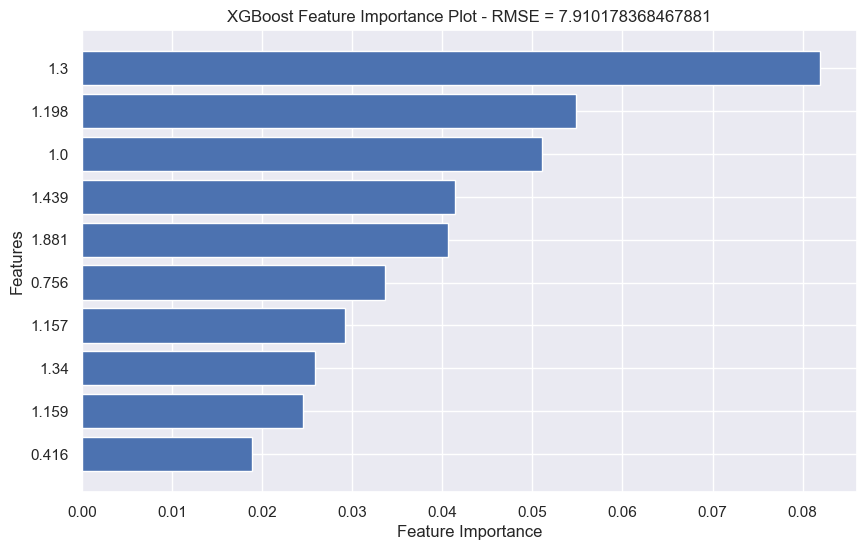

In [ ]:
num_features = 10

# Get feature importances
xgb_feature_importances = xgb_reg.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(xgb_feature_importances)[-num_features:]
xgb_feature_importance_map = dict(zip(feature_names[feature_idx], xgb_feature_importances[feature_idx]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_feature_importance_map)), list(xgb_feature_importance_map.values()), align='center')
plt.yticks(range(len(xgb_feature_importance_map)), list(xgb_feature_importance_map.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'XGBoost Feature Importance Plot - RMSE = {xgb_rmse}')
plt.show()

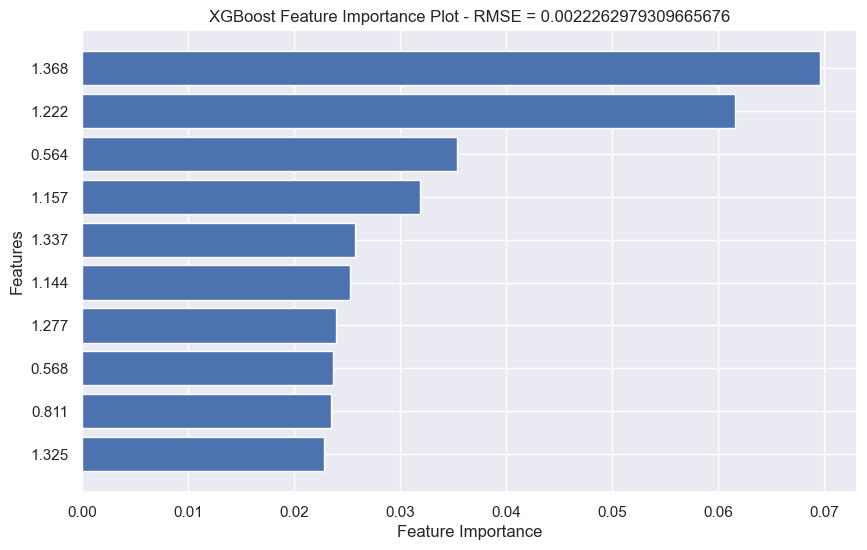

In [ ]:
num_features = 10

# Get feature importances
xgb_feature_importances_5cv = xgb_reg_5cv.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(xgb_feature_importances_5cv)[-num_features:]
xgb_feature_importance_map_5cv = dict(zip(feature_names[feature_idx], xgb_feature_importances_5cv[feature_idx]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_feature_importance_map_5cv)), list(xgb_feature_importance_map_5cv.values()), align='center')
plt.yticks(range(len(xgb_feature_importance_map_5cv)), list(xgb_feature_importance_map_5cv.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'XGBoost Feature Importance Plot - RMSE = {xgb_rmse_test_5cv}')
plt.show()

In [ ]:
list(xgb_feature_importance_map_5cv.keys())  # These are the top 10 wavelengths.

[1.325, 0.811, 0.568, 1.277, 1.144, 1.337, 1.157, 0.564, 1.222, 1.368]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize LGBMRegressor
lgb_reg = lgb.LGBMRegressor(random_state=42)

# Fit the model to training data
lgb_reg.fit(X_train, y_train);

# Predict on the testing data
y_pred = lgb_reg.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
lgb_rmse = np.sqrt(mse)
print("Root Mean Squared Error:", lgb_rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232189
[LightGBM] [Info] Number of data points in the train set: 322, number of used features: 2151
[LightGBM] [Info] Start training from score 46.754441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
### LGBM WITH 5-FOLD CROSS VALIDATION ###

import lightgbm as lgb

# Initialize LGBMRegressor
lgb_reg_5cv = lgb.LGBMRegressor()

# Fit the model to training data
lgb_reg_5cv.fit(X, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
lgb_cv_scores = cross_val_score(lgb_reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -lgb_cv_scores)
print("Mean squared error across all folds:", -np.mean(lgb_cv_scores))

# Predict on the testing data
y_pred_lgb_5cv = lgb_reg_5cv.predict(X)

# Calculate and print the mean squared error on the test set
lgb_mse_test = mean_squared_error(y, y_pred_lgb_5cv)
lgb_rmse_test = np.sqrt(lgb_mse_test)
print("Mean squared error on test set:", lgb_mse_test)
print("Root Mean Squared Error on Test Set:", lgb_rmse_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331089
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 2151
[LightGBM] [Info] Start training from score 46.728739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

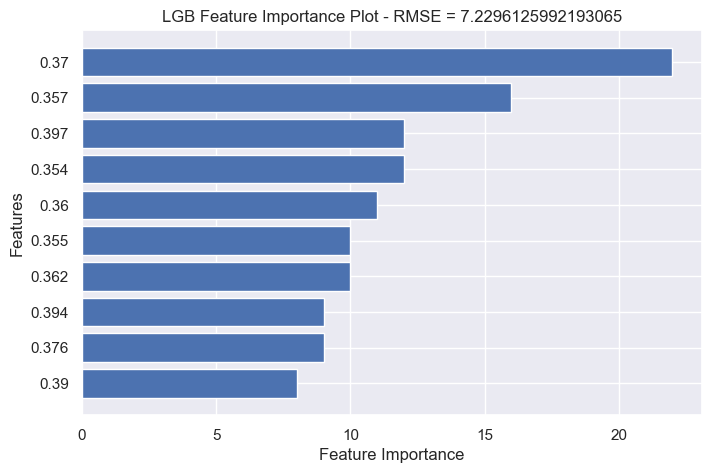

In [ ]:
num_features = 10

# Get feature importances
lgb_feature_importances = lgb_reg.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(lgb_feature_importances)[-num_features:]
lgb_feature_importance_map = dict(zip(feature_names[feature_idx], lgb_feature_importances[feature_idx]))

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.values()), align='center')
plt.yticks(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'LGB Feature Importance Plot - RMSE = {lgb_rmse}')
plt.show()

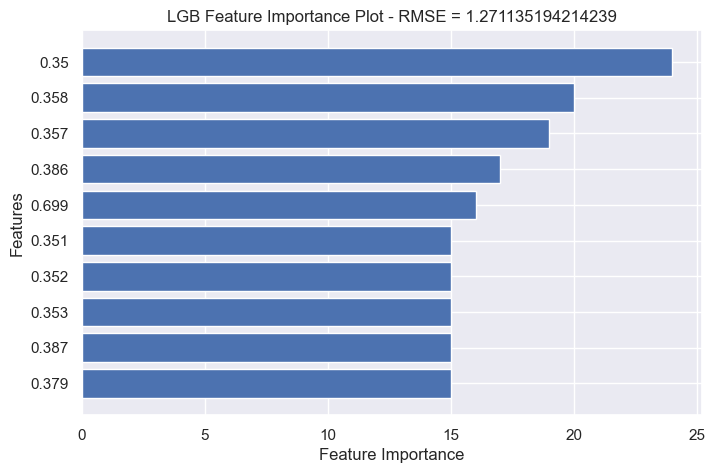

In [ ]:
num_features = 10

# Get feature importances
lgb_feature_importances_5cv = lgb_reg_5cv.feature_importances_

# Map feature names to importance scores
feature_idx = np.argsort(lgb_feature_importances_5cv)[-num_features:]
lgb_feature_importance_map = dict(zip(feature_names[feature_idx], lgb_feature_importances_5cv[feature_idx]))

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.values()), align='center')
plt.yticks(range(len(lgb_feature_importance_map)), list(lgb_feature_importance_map.keys()))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'LGB Feature Importance Plot - RMSE = {lgb_rmse_test}')
plt.show()

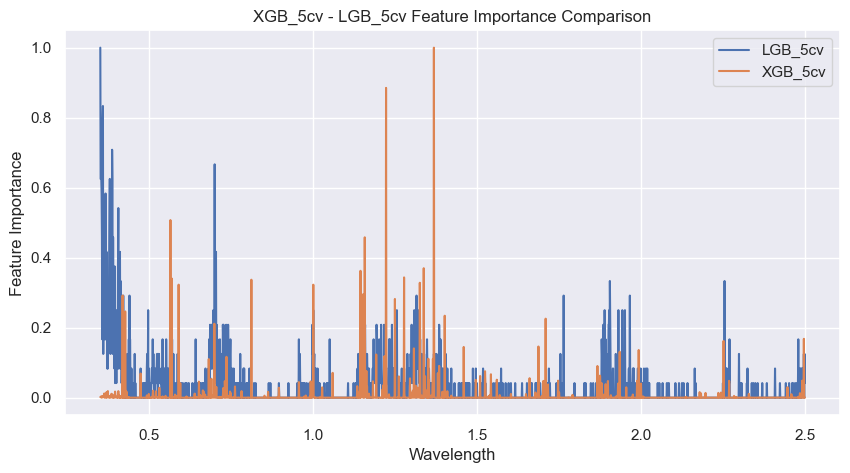

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(feature_names, lgb_feature_importances_5cv/np.max(lgb_feature_importances_5cv), label='LGB_5cv')
plt.plot(feature_names, xgb_feature_importances_5cv/np.max(xgb_feature_importances_5cv), label='XGB_5cv')
#plt.plot(feature_names, shap_top10/np.max(shap_top10))
plt.xlabel('Wavelength')
plt.ylabel('Feature Importance')
plt.title(f'XGB_5cv - LGB_5cv Feature Importance Comparison')
plt.legend()

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Initialize the SVR model
svr = SVR(kernel='rbf', C=5, gamma='scale')  # adjust parameters like kernel, C, and gamma

# Train the SVR model using selected features
svr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 10.371333988284247


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import LinearSVR  # Import LinearSVR for feature selection
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# Assuming you have loaded your hyperspectral data into X and corresponding continuous targets into y
# Ensure X is a 2D array where each row represents a flattened hyperspectral image
# Ensure y is a 1D array containing the corresponding continuous target values for each image

# Initialize the LinearSVR model
linear_svr = LinearSVR(random_state=42, dual=True)

# Initialize Recursive Feature Elimination (RFE) with SVR
rfe = RFE(estimator=linear_svr, n_features_to_select=200)  # adjust the number of features to select

# Fit RFE to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = rfe.support_

# Transform the training and testing sets to contain only the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Initialize the SVR model
svr = SVR(kernel='rbf', C=5.0, gamma='scale')  # adjust parameters like kernel, C, and gamma

# Train the SVR model using selected features
svr.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = svr.predict(X_test_selected)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 10.287974811955262


In [ ]:
results_df = pd.DataFrame(columns=['Regressor', 'MSE', 'RMSE', 'R-Squared'])

In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# Initialize Regressor
reg_name = 'Random Forest, n=10'
reg_5cv = RandomForestRegressor(n_estimators=10)

# Fit the model to training data
reg_5cv.fit(X, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df

Mean squared error for each fold: [60.81479998 60.61208838 54.84825202 68.80211332 62.54051034]
Mean squared error across all folds: 61.52355280652174


,Regressor,MSE,RMSE,R-Squared
0,"Random Forest, n=10",10.54,3.25,0.91


In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# Initialize Regressor
reg_name = 'Random Forest, n=10'
reg_5cv = RandomForestRegressor(n_estimators=10)

# Fit the model to training data
reg_5cv.fit(X, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df

Mean squared error for each fold: [60.81479998 60.61208838 54.84825202 68.80211332 62.54051034]
Mean squared error across all folds: 61.52355280652174


,Regressor,MSE,RMSE,R-Squared
0,"Random Forest, n=10",10.54,3.25,0.91


In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Initialize Regressor
reg_name = 'SVR'
reg_5cv = SVR(kernel='rbf', C=5, gamma='scale')

# Fit the model to training data
reg_5cv.fit(X, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df_hist = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df_hist

Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Mean squared error for each fold: [108.86443202 116.90375585 101.04296564 111.48876749  77.45194292]
Mean squared error across all folds: 103.15037278421855


,Regressor,MSE,RMSE,R-Squared
0,SVR,100.863395,10.043077,0.114016


In [ ]:
### TEMPLATE REGRESSOR WITH 5-FOLD CROSS VALIDATION on TOP FEATURES ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Initialize Regressor
reg_name = 'HistGradientBoostingRegressor'
reg_5cv = HistGradientBoostingRegressor()

# Fit the model to training data
reg_5cv.fit(X_top_bands, y);

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(reg_5cv, X_top_bands, y, cv=kf, scoring='neg_mean_squared_error')

# Print the mean cross-validation scores
print("Mean squared error for each fold:", -cv_scores)
print("Mean squared error across all folds:", -np.mean(cv_scores))

# Predict on the testing data
y_pred_5cv = reg_5cv.predict(X_top_bands)

# Calculate and print the MSE, RMSE, R-Squared on the test set
mse_test = mean_squared_error(y, y_pred_5cv)
rmse_test = np.sqrt(mse_test)
#print("MSE on Test Set:", mse_test)
#print("RMSE on Test Set:", rmse_test)
r_sq_test = r2_score(y, y_pred_5cv)
#print("R-squared on Test Set:", r_sq_test)

# Create a new DataFrame to store the results
results_df_hist = pd.DataFrame({'Regressor': [reg_name],
    'MSE': [mse_test],
    'RMSE': [rmse_test],
    'R-Squared': [r_sq_test]})

# Append results to DataFrame
# results_df = results_df.append(df_append, ignore_index=True)

results_df_hist

Mean squared error for each fold: [48.08341823 54.79761251 74.94295621 42.07968144 59.55834766]
Mean squared error across all folds: 55.89240320899246


,Regressor,MSE,RMSE,R-Squared
0,HistGradientBoostingRegressor,4.89,2.21,0.96


In [ ]:
# Create new Dataframe to store all results
results_df = pd.DataFrame(columns=['Sensor', 'Substance', 'Model', 'Dataset', 'MSE', 'RMSE', 'R-Squared'])


In [ ]:
### FUNCTION FOR REGRESSOR WITH 5-FOLD CROSS VALIDATION ###

from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

def run_model(sensor, substance, reg_name, dataset, reg_5cv, X):
    
    results_df = pd.DataFrame(columns=['Sensor', 'Substance', 'Model', 'Dataset', 'MSE', 'RMSE', 'R-Squared'])

    # Fit the model to training data
    reg_5cv.fit(X, y);

    # Define the KFold cross-validation object
    kf = KFold(n_splits=5, shuffle=True)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(reg_5cv, X, y, cv=kf, scoring='neg_mean_squared_error')

    # Print the mean cross-validation scores
    #print("Mean squared error for each fold:", -cv_scores)
    #print("Mean squared error across all folds:", -np.mean(cv_scores))

    # Predict on the testing data
    y_pred_5cv = reg_5cv.predict(X)

    # Calculate and print the MSE, RMSE, R-Squared on the test set
    mse_test = mean_squared_error(y, y_pred_5cv)
    rmse_test = np.sqrt(mse_test)
    #print("MSE on Test Set:", mse_test)
    #print("RMSE on Test Set:", rmse_test)
    r_sq_test = r2_score(y, y_pred_5cv)
    #print("R-squared on Test Set:", r_sq_test)

    # Append results to DataFrame
    results_df = results_df._append({'Sensor': sensor,
        'Substance': substance,
        'Model': reg_name,
        'Dataset': dataset,
        'MSE': mse_test,
        'RMSE': rmse_test,
        'R-Squared': r_sq_test}, ignore_index=True)

    return(results_df)

In [ ]:
run_model('ASD', 'Water', 'HistGradientBoostingRegressor', 'Top 20 Bands',  HistGradientBoostingRegressor(), X_top_bands)

,Sensor,Substance,Model,Dataset,MSE,RMSE,R-Squared
0,ASD,Water,HistGradientBoostingRegressor,Top 20 Bands,4.89,2.21,0.96


In [ ]:
run_model('ASD', 'Water', 'RandomForestRegressor', 'Top 20 Bands', RandomForestRegressor(n_estimators=10), X_top_bands)

,Sensor,Substance,Model,Dataset,MSE,RMSE,R-Squared
0,ASD,Water,RandomForestRegressor,Top 20 Bands,10.46,3.23,0.91


In [ ]:
results_df = pd.DataFrame(columns=['Sensor', 'Substance', 'Model', 'Dataset', 'MSE', 'RMSE', 'R-Squared'])
results_df

,Sensor,Substance,Model,Dataset,MSE,RMSE,R-Squared


In [ ]:
import pandas as pd

sensor = 'ASD'
substance = 'Water'
reg_name = 'HistGradientBoostingRegressor'
dataset = 'X'
mse_test = 4.89
rmse_test = 2.21
r_sq_test = 0.96

results_df._append({'Sensor': sensor,
        'Substance': substance,
        'Model': reg_name,
        'Dataset': dataset,
        'MSE': mse_test,
        'RMSE': rmse_test,
        'R-Squared': r_sq_test}, ignore_index=True)

,Sensor,Substance,Model,Dataset,MSE,RMSE,R-Squared
0,ASD,Water,HistGradientBoostingRegressor,X,4.89,2.21,0.96


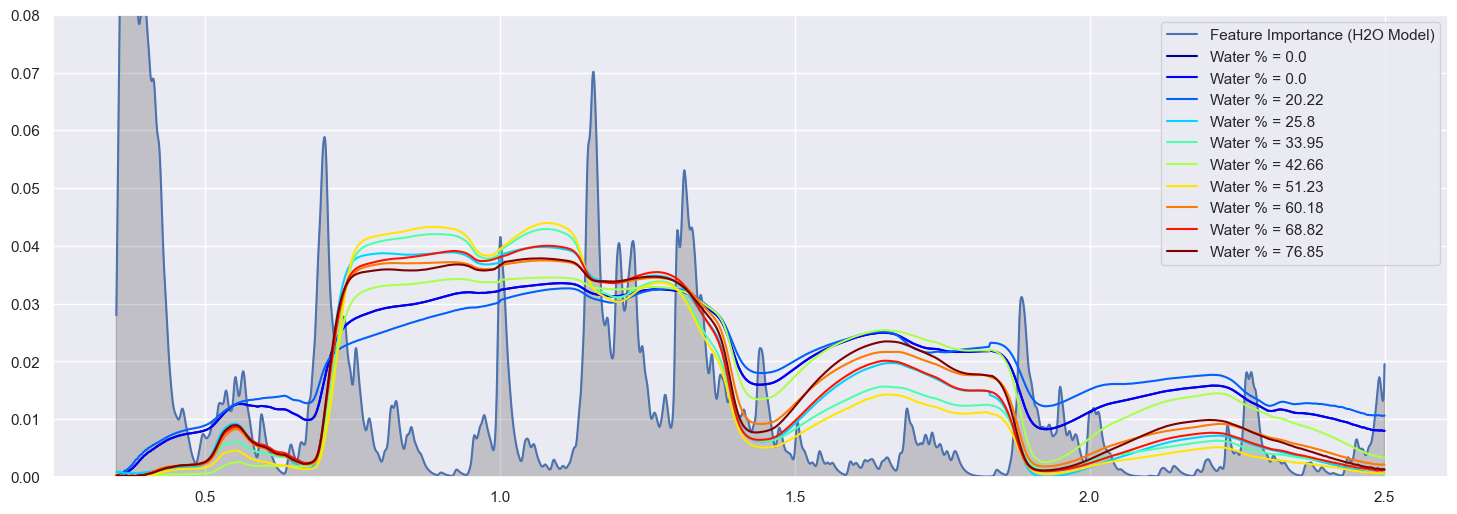

In [ ]:
band_import = lgb_feature_importances/np.max(lgb_feature_importances) + xgb_feature_importances/np.max(xgb_feature_importances)
band_import_smooth = np.zeros(len(band_import))

w = 5
filt = np.zeros(2*w+1)
for i in range(w+1):
    filt[i] = np.exp((-1/9)*(i)**2)
for i in range(len(band_import)):
    s = np.max([0,i-w])
    e = np.min([i+w,len(band_import)])
    sm = 0
    for j in range(s,e):
        band_import_smooth[i] = band_import_smooth[i] + filt[np.abs(i-j)]*band_import[j]
        sm = sm + filt[np.abs(i-j)]
    band_import_smooth[i] = band_import_smooth[i]/sm

band_import = band_import_smooth
w = 5
filt = np.zeros(2*w+1)
for i in range(w+1):
    filt[i] = np.exp((-1/9)*(i)**2)
for i in range(len(band_import)):
    s = np.max([0,i-w])
    e = np.min([i+w,len(band_import)])
    sm = 0
    for j in range(s,e):
        band_import_smooth[i] = band_import_smooth[i] + filt[np.abs(i-j)]*band_import[j]
        sm = sm + filt[np.abs(i-j)]
    band_import_smooth[i] = band_import_smooth[i]/sm
    

plt.figure(figsize=(18,6))
plt.plot(feature_names, band_import_smooth/np.linalg.norm(band_import_smooth), label='Feature Importance (H2O Model)');
plt.fill_between(feature_names,band_import_smooth/np.linalg.norm(band_import_smooth), color='k', alpha=0.2)
for i,c in zip(idx,colors):
    plt.plot(feature_names,X[i,:], label=f'Water % = {y[i]}', c=c)
plt.ylim([0,0.08]);
plt.legend();

NameError: name 'findOccurrences' is not defined

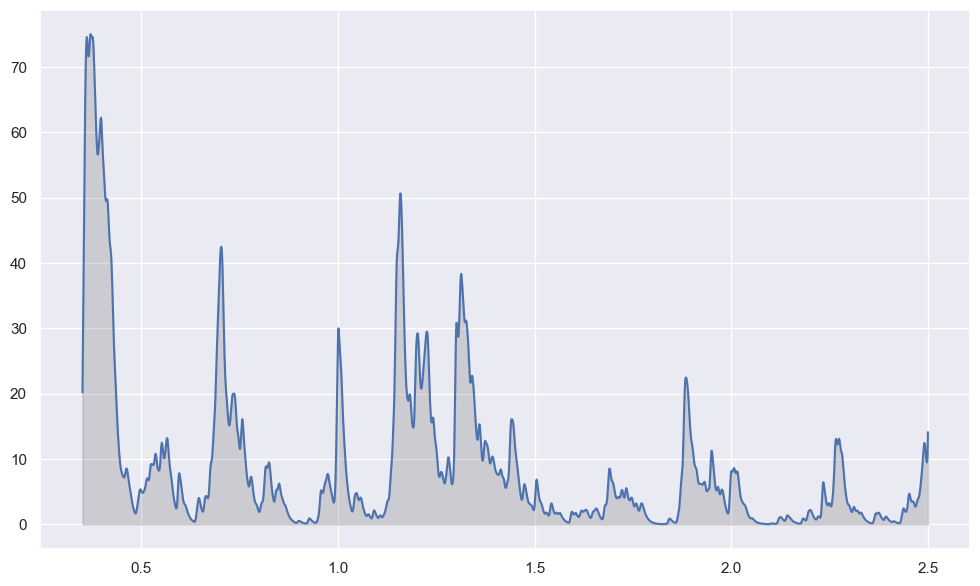

In [ ]:
lgb_feature_importances_normalized = lgb_feature_importances/np.max(lgb_feature_importances)
xgb_feature_importances_normalized =  xgb_feature_importances/np.max(xgb_feature_importances)
lgb_top_10 = feature_names[np.argsort(-lgb_feature_importances_normalized)[:20]]
xgb_top_10 = feature_names[np.argsort(-xgb_feature_importances_normalized)[:20]]

plt.figure()
plt.plot(feature_names, 75*band_import_smooth/np.max(band_import_smooth), label='Feature Importance (H2O Model)');
plt.fill_between(feature_names,75*band_import_smooth/np.max(band_import_smooth), color='k', alpha=0.15)
for i,c in zip(idx,colors):
    veg_name = lib.names[i][1+findOccurrences(lib.names[i], '.')[0]:findOccurrences(lib.names[i], '.')[3]]
    plt.plot(feature_names,X1[i,:], label=veg_name+f' (Water % = {y[i]})', c=c, linewidth=2)

    plt.vlines(lgb_top_10, ymin=0, ymax=100, color='orange', linewidth=4, alpha=0.5, label='lgb Most Important Bands')
plt.vlines(xgb_top_10, ymin=0, ymax=100, color='blue', linewidth=4, alpha=0.5, label='xgb Most Important Bands')
plt.legend();
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.title('Bands Important for % Water-Content Estimation');

In [ ]:
band_import_smooth

array([0.30328591, 0.40302747, 0.50281458, ..., 0.15942326, 0.17840299,
       0.23408921])

In [ ]:
len(data)

1040

In [ ]:
type(data)

dict

In [ ]:
### GENETIC ALGORITM (GA) ###

import numpy as np
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define the fitness function
def fitness_function(selected_bands, data, labels):

    # Select only the data for the selected bands
    selected_data = data[:, selected_bands]

    # Create a classifier
    #knn = KNeighborsClassifier(n_neighbors=10)

    # Calculate cross-validated accuracy
    #scores = cross_val_score(knn, selected_data, labels, cv=5)
    scores = cross_val_score(xgb_reg, selected_data, labels, cv=5)
    accuracy = np.mean(scores)

    return accuracy

# Genetic Algorithm
def genetic_algorithm(data, labels, pop_size=20, generations=50, mutation_rate=0.1):
    num_bands = data.shape[1]
    pop = np.random.choice([0, 1], size=(pop_size, num_bands), replace=True)
    
    for gen in range(generations):
        # Evaluate fitness
        fitness_scores = np.array([fitness_function(selected_bands, data, labels) for selected_bands in pop])

        # Selection
        selected_indices = np.argsort(fitness_scores)[-int(pop_size/2):]
        selected_pop = pop[selected_indices]

        # Crossover
        new_pop = []
        for _ in range(pop_size - len(selected_pop)):
            #flattened_selected_pop = selected_pop.flatten()  # or selected_pop.reshape(-1)
            #parent1, parent2 = np.random.choice(flattened_selected_pop, size=2, replace=False)
            parent1, parent2 = np.random.choice(selected_pop, size=2, replace=False)
            crossover_point = np.random.randint(num_bands)
            child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            new_pop.append(child)

        # Mutation
        for i in range(len(new_pop)):
            if np.random.rand() < mutation_rate:
                mutation_point = np.random.randint(num_bands)
                new_pop[i][mutation_point] = 1 - new_pop[i][mutation_point]

        pop = np.array(new_pop)

    # Select the best solution
    best_solution_index = np.argmax(fitness_scores)
    best_solution = pop[best_solution_index]

    return best_solution

# Example usage
if __name__ == "__main__":
    # Generate some sample data
    num_samples = 1000
    num_bands = 20
    num_classes = 2
    data = np.random.rand(num_samples, num_bands)
    labels = np.random.randint(num_classes, size=num_samples)

    # Run genetic algorithm
    selected_bands = genetic_algorithm(data, labels)

    print("Selected bands:", selected_bands)


IndexError: invalid index to scalar variable.

In [ ]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/c8/02/d3adf4b4851d99a31c5a9cf7b668f171e84334945d05fb7b51c42bf41abf/torch-2.2.0-cp311-cp311-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/81/54/84d42a0bee35edba99dee7b59a8d4970eccdd44b99fe728ed912106fc781/filelock-3.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/b7/f4/6a90020cd2d93349b442bfcb657d0dc91eee65491600b2cb1d388bc98e6b/typing_extensions-4.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy from https://files.pythonhosted.org/packages/d2/05/e6600db80270777c4a64238a98d442f0fd07cc8915be2a1c16da7f2b9e74/sympy-1.12-py3-none-any.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.1.105 from https://fil

In [ ]:
import torch

# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
### SEQUENTIAL FORWARD SELECTION (SFS) WITH XGB ###

import numpy as np
from sklearn.model_selection import cross_val_score
#from sklearn.neighbors import KNeighborsClassifier

def fitness_function(selected_bands, data, labels):
    # Use a simple classifier, e.g., k-Nearest Neighbors
    #knn = KNeighborsClassifier(n_neighbors=3)
    selected_data = data[:, selected_bands]
    scores = cross_val_score(xgb_reg, selected_data, labels, cv=5)
    accuracy = np.mean(scores)
    return accuracy

def sequential_forward_selection(data, labels, num_selected_features):
    num_bands = data.shape[1]
    selected_features = []
    remaining_features = list(range(num_bands))

    for _ in range(num_selected_features):
        best_accuracy = -1
        best_feature = None

        for feature in remaining_features:
            current_selection = selected_features + [feature]
            accuracy = fitness_function(current_selection, data, labels)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

if __name__ == "__main__":

    # Run Sequential Forward Selection
    num_selected_features = 10
    selected_bands = sequential_forward_selection(X_train, y_train, num_selected_features)

    print("Selected bands:", selected_bands)


KeyboardInterrupt: 

In [ ]:
### SEQUENTIAL FORWARD SELECTION (SFS) WITH KNN ###

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def fitness_function(selected_bands, data, labels):
    # Use a simple classifier, e.g., k-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=3)
    selected_data = data[:, selected_bands]
    scores = cross_val_score(knn, selected_data, labels, cv=5)
    accuracy = np.mean(scores)
    return accuracy

def sequential_forward_selection(data, labels, num_selected_features):
    num_bands = data.shape[1]
    selected_features = []
    remaining_features = list(range(num_bands))

    for _ in range(num_selected_features):
        best_accuracy = -1
        best_feature = None

        for feature in remaining_features:
            current_selection = selected_features + [feature]
            accuracy = fitness_function(current_selection, data, labels)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

# Example usage
if __name__ == "__main__":
    # Generate some sample data
    num_samples = 1000
    num_bands = 20
    num_classes = 2
    sfs_data = np.random.rand(num_samples, num_bands)
    labels = np.random.randint(num_classes, size=num_samples)

    # Run Sequential Forward Selection
    num_selected_features = 5
    selected_bands = sequential_forward_selection(sfs_data, labels, num_selected_features)

    print("Selected bands:", selected_bands)


In [ ]:
X_train.shape